In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt


## This is your original code (except I changed the name of the File object to h5file so that no confusion between the object and Python builtin file command)

In [2]:


data_dir = 'SSJ_bins/'
filename = data_dir + 'magcloudnoshocks_ssj_ele_lowmid_1.h5'

h5file = h5.File(filename, 'r')
names = h5file.keys()

# Retrieving 'binstats_results' using the following two methods returns the same thing                                                 
binstats1 = h5file['binstats_results'] 
binstats2 = h5file.get('binstats_results')

bin_keys = binstats2.keys()

data = binstats2.get('binstats_nzmedian')


### Here I will go through how to get the bin start and ends. The key point that I guess I did not communicate well is that the bins each have their own group (like the `binstats_results` group) and you have to loop through the bin groups to get information on the bins

In [3]:
#---------------------------------------------------------------------------------
#'binstats' group only contains the statistics from each bin, not the definitions
#of the bin boundaries in latitude and local time (or longitude)
#
#We will need to loop through the bins, each one of which has it's own group
#and get their dimensions
#
#---------------------------------------------------------------------------------

#Find out how many bins there are by looking at the length of 'data'
n_bins = data.shape[0]

#Now we create some all-NaN arrays to store the bin dimension data in
slats,elats = np.full((n_bins,1),np.nan),np.full((n_bins,1),np.nan) # Latitude bounds of bins
slts,elts = np.full((n_bins,1),np.nan),np.full((n_bins,1),np.nan) # Local time bounds of bin

#Now we loop through the bin groups in the HDF5
#file, extracting the boundaries of each bin from
#it's respective group
for bin_index in range(n_bins):
    bin_group_name = 'bin%d' % (bin_index)
    #If there was no data that fell in a particular
    #bin, no group will exist for it in the file
    #so we now check if there's a group for bin_index-th bin
    if bin_group_name in h5file:
        #Now we extract the boundaries of the bin from its group's HDF5 attributes
        bin_group = h5file[bin_group_name]
        slats[bin_index] = bin_group.attrs['slat']
        elats[bin_index] = bin_group.attrs['elat']
        slts[bin_index] = bin_group.attrs['slt']
        elts[bin_index] = bin_group.attrs['elt']
        """
        print("%s bounds (%f,%f),(%f,%f)" % (bin_group_name,
                                              slats[bin_index],elats[bin_index],
                                              slts[bin_index],elts[bin_index]))
        """
    else:
        #print("No group %s" % (bin_group_name))
        continue

 ### Now here is some code that shows how to scatterplot the bin values at the center of each bin in the top-down polar plot format that our group uses a lot

In [7]:
#----------------------------------------------------------------------------------------------
# We need some coordinate transform functions and angle handling helper functions to do this
#----------------------------------------------------------------------------------------------
def latlt2polar(lat,lt,hemisphere):
    """
    Converts an array of latitude and lt points to polar for a top-down dialplot (latitude in degrees, LT in hours)
    i.e. makes latitude the radial quantity and MLT the azimuthal 

    get the radial displacement (referenced to down from northern pole if we want to do a top down on the north, 
    or up from south pole if visa-versa)
    """
    from numpy import pi
    if hemisphere=='N':
        r = 90.-lat
    elif hemisphere=='S':
        r = 90.-(-1*lat)
    else:
        raise ValueError('%s is not a valid hemisphere, N or S, please!' % (hemisphere))
    #convert lt to theta (azimuthal angle) in radians
    theta = lt/24. * 2*pi

    #the pi/2 rotates the coordinate system from
    #theta=0 at negative y-axis (local time) to
    #theta=0 at positive x axis (traditional polar coordinates)
    return r,theta

def angle_difference(ang1,ang2,degorhour='hour'):
    """Difference between two angles in degrees or hours (ang2-ang1), 
    taking into account wrapping
    """
    ang2rad = np.pi/12. if degorhour=='hour' else np.pi/180.
    return np.arctan2(np.sin(ang2*ang2rad-ang1*ang2rad), np.cos(ang2*ang2rad-ang1*ang2rad))/ang2rad

def angle_midpoint(ang1,ang2,degorhour='hour'):
    """
    Midpoint between two angles in degrees or hours
    """
    return ang1 + angle_difference(ang1,ang2,degorhour=degorhour)/2.

/home/liamk/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


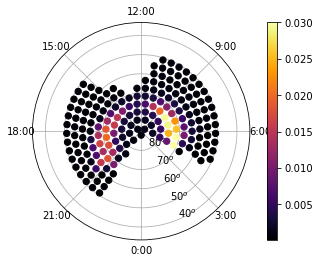

In [8]:
#It will be useful for plotting purposes to have just one 
#lat,local time coordinate for each bin, so we'll use
#the functions defined at the top
lats = angle_midpoint(slats,elats,degorhour='deg')
lts = angle_midpoint(slts,elts,degorhour='hour')

#Let's look at Northern hemisphere polar region only
N = lats > 50.

#Now we can turn latitude and local time into the 
#typical 'top-down' (looking down on the North or South pole)
#polar coordinates
rN,thetaN = latlt2polar(lats[N],lts[N],'N')
dataN = data[N]

#Now we can finally try to plot and see what we get
f = plt.figure()
ax = f.add_subplot(111,projection='polar')

dot_size = 40
mappable = ax.scatter(thetaN,rN,dot_size,dataN,cmap='inferno',zorder=10,vmax=.03)
plt.colorbar(mappable,ax=ax)

#Rotate the plot so that noon is at the top and midnight
#is at the bottom, and fix the labels so radial direction
#is latitude and azimuthal direction is local time in hours
ax.set_theta_zero_location('S')
theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
ax.set_thetagrids(theta_label_values,labels=theta_labels)

r_label_values = 90.-np.array([80.,70.,60.,50.,40.])
r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
ax.set_rgrids(r_label_values,labels=r_labels)

plt.show()
